In [2]:
!pip install pycaret

     |████████████████████████████████| 261 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.2 MB 5.6 MB/s eta 0:00:01    |███▊                            | 1.7 MB 4.4 MB/s eta 0:00:03     |███████▋                        | 3.4 MB 4.4 MB/s eta 0:00:03     |█████████████████████           | 9.3 MB 4.5 MB/s eta 0:00:02
     |████████████████████████████████| 1.3 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 7.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 102 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 7.7 MB/s eta 0:00:01
     |█████████████

In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime
import torch
import time
from datetime import datetime

In [2]:
def setSeeds(seed = 42):
    # 랜덤 시드를 설정하여 매 코드를 실행할 때마다 동일한 결과를 얻게 합니다.
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
setSeeds(42)

In [3]:
def feature_split_user(df):
    new_df = df.copy()
    new_df["newUserID"] = df['assessmentItemID'].apply(lambda x:x[:3]) + df['userID'].astype(str)
    return new_df

def get_remain_test_data(df_test):
    get_new_id = set(df_test.loc[df_test.answerCode == -1, 'newUserID'])    
    test_data = df_test[df_test.newUserID.isin(get_new_id)]
    remain_data = df_test.drop(test_data.index)
    return test_data, remain_data
# time convert
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

In [4]:
train_path = '/opt/ml/input/data/train_dataset/train_data.csv'
test_path = '/opt/ml/input/data/train_dataset/test_data.csv'

df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

df_train = feature_split_user(df_train_ori)
df_test = feature_split_user(df_test_ori)

df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것
df_test, remain_data = get_remain_test_data(df_test)
df_train = pd.concat([df_train, remain_data])

df_train['Timestamp'] = df_train['Timestamp'].apply(convert_time)
df_test['Timestamp'] = df_test['Timestamp'].apply(convert_time)

df_train_test = pd.concat([df_train, df_test['answerCode'], df_test[df_test['answerCode'] != -1]])

In [5]:
# trian에서 각 문제 평균 뽑기
testId_mean_sum = df_train_test.groupby(['testId'])['answerCode'].agg(['mean','sum']).to_dict()
assessmentItemID_mean_sum = df_train_test.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']).to_dict()
KnowledgeTag_mean_sum = df_train_test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum']).to_dict()

In [8]:
# new user id 겹치는거 없음 확인
s1 = set(df_test.loc[:, 'userID'])
s2 = set(df_train.loc[:, 'userID'])
# s1 & s2

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


## Feature engineering
### 한번만 실행되도록 설정

In [9]:
def feature_engineering(df_ori):
    df = df_ori.copy()
    def assessmentItemID2item(x):
        return int(x[-3:]) - 1
    df['item'] = df.assessmentItemID.map(assessmentItemID2item)
    # testId별로 나오는 문제 갯수
    item_size = df[['assessmentItemID', 'testId']].drop_duplicates().groupby('testId').size()
    testId2maxlen = item_size.to_dict() # 중복해서 풀이할 놈들을 제거하기 위해
    
    item_max = df.groupby('testId')['item'].max()

    # 순서대로 풀지 않은 문제의 index
    not_order_index = item_max[item_max +1 != item_size].index    
    not_order_test = df.loc[df.testId.isin(not_order_index)][['assessmentItemID','testId']].drop_duplicates().sort_values('assessmentItemID')
    not_order_group = not_order_test.groupby('testId')

    not_order_ID2item = {}
    for key in not_order_group.groups:
        for i, (k, _) in enumerate(not_order_group.get_group(key).values):
            not_order_ID2item[k] = i
    
    def assessmentItemID2item_order(x):
        if x in not_order_ID2item:
            return int(not_order_ID2item[x])
        return int(x[-3:]) -1
    df['orded_item'] = df.assessmentItemID.map(assessmentItemID2item_order)
    df_group = df.groupby(['newUserID','testId'])['answerCode']
    #user 별 이전까지 맞춘개수, 현재까지 맞춘개수, 현재 정답률
    df['user_correct_answer'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df_group.cumcount()
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    
    #한 test안에서 마지막으로 푼 문제으로 부터 지난 시간
    df['prev_timestamp'] = df.groupby('testId')['Timestamp'].shift(0) - df.groupby('testId')['Timestamp'].shift(1)
    
    # user 별 마지막으로 푼 tag로부터 지난 시간, NaN값은 300으로 한다.
    prev_timestamp_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['Timestamp']].shift()
    df['diff_time_btw_KnowledgeTag_ids'] = (df['Timestamp'] - prev_timestamp_ac['Timestamp']).fillna(300)
    
    # 각 tag 별 마지막으로 풀었을때 정답 여부
    prev_correct_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['answerCode']].shift()        
    df['prev_answered_correctly'] = prev_correct_ac['answerCode'].fillna(0)
    
    df["test_sum"] = df.testId.map(testId_mean_sum['sum'])
    df["test_mean"] = df.testId.map(testId_mean_sum['mean'])
    df["ItemID_sum"] = df.assessmentItemID.map(assessmentItemID_mean_sum['sum'])
    df["ItemID_mean"] = df.assessmentItemID.map(assessmentItemID_mean_sum['mean'])
    df["tag_sum"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['sum'])
    df["tag_mean"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['mean'])
    
    
    #test, Item, tag 별 상대적 정답률
    df['relative_test_answer'] = df['answerCode'] - df['test_mean']
    df['relative_ItemID_answer'] = df['answerCode'] - df['ItemID_mean']
    df['relative_tag_answer'] = df['answerCode'] - df['tag_mean']
    
    #이동평균선 5, 10, 15, 20, 25, 30
#     df['ma5'] = df['user_acc'].fillna(0).rolling(window=5).mean()
#     df['ma10'] = df['user_acc'].fillna(0).rolling(window=10).mean()
#     df['ma15'] = df['user_acc'].fillna(0).rolling(window=15).mean()
#     df['ma20'] = df['user_acc'].fillna(0).rolling(window=20).mean()
#     df['ma25'] = df['user_acc'].fillna(0).rolling(window=25).mean()
#     df['ma30'] = df['user_acc'].fillna(0).rolling(window=30).mean()
    df_group = df.groupby('newUserID')['answerCode']
    df['user_ma5'] = df_group.transform(lambda x: x.shift(1).rolling(window=5).mean())
    df['user_ma10'] = df_group.transform(lambda x: x.shift(1).rolling(window=10).mean())
    df['user_ma15'] = df_group.transform(lambda x: x.shift(1).rolling(window=15).mean())
    df['user_ma20'] = df_group.transform(lambda x: x.shift(1).rolling(window=20).mean())
    df['user_ma25'] = df_group.transform(lambda x: x.shift(1).rolling(window=25).mean())
    df['user_ma30'] = df_group.transform(lambda x: x.shift(1).rolling(window=30).mean())

    #MACD
    df['MACD'] = df['user_ma15'] - df['user_ma25']
    
    #Standard Deviation 5,10, 15, 20, 25, 30
#     df['sd5'] = df['user_acc'].fillna(0).rolling(window=5).std()
#     df['sd10'] = df['user_acc'].fillna(0).rolling(window=10).std()
#     df['sd15'] = df['user_acc'].fillna(0).rolling(window=15).std()
#     df['sd20'] = df['user_acc'].fillna(0).rolling(window=20).std()
#     df['sd25'] = df['user_acc'].fillna(0).rolling(window=25).std()
#     df['sd30'] = df['user_acc'].fillna(0).rolling(window=30).std()
    df["user_sd5"] = df_group.transform(lambda x: x.shift(1).rolling(window=5).std())
    df["user_sd10"] = df_group.transform(lambda x: x.shift(1).rolling(window=10).std())
    df["user_sd15"] = df_group.transform(lambda x: x.shift(1).rolling(window=15).std())
    df["user_sd20"] = df_group.transform(lambda x: x.shift(1).rolling(window=20).std())
    df["user_sd25"] = df_group.transform(lambda x: x.shift(1).rolling(window=25).std())
    df["user_sd30"] = df_group.transform(lambda x: x.shift(1).rolling(window=30).std())
    
    #볼린저 밴드
    df['Upper BollingerBand'] = df['user_ma10'] + (df['user_sd10'] * 3)
    df['Lower BollingerBand'] = df['user_ma10'] - (df['user_sd10'] * 3)
    
    #이전에 같은 item, tag 몇 번 풀었는지
    df['prior_ItemID_frequency'] = df.groupby(['newUserID', 'assessmentItemID']).cumcount()
    df['prior_tag_frequency'] = df.groupby(['newUserID', 'KnowledgeTag']).cumcount()
    
    df["grade"] = df["assessmentItemID"].apply(lambda x: x[2]).astype('category')
    #망각 곡선TOD
    return df

In [10]:
if os.path.exists("fe_train2.csv") and os.path.exists("fe_test2.csv"):
    FE_train = pd.read_csv("fe_train2.csv")
    FE_test = pd.read_csv("fe_test2.csv")
    FE_train.drop('Unnamed: 0', axis=1, inplace=True)
    FE_test.drop('Unnamed: 0', axis=1, inplace=True)
    print("cache dataset complete")
else:
    print("working on feature engineering.")
    FE_train = feature_engineering(df_train)
    FE_test = feature_engineering(df_test)
    FE_train.to_csv('fe_train2.csv')
    FE_test.to_csv('fe_test2.csv')
    print("save dataset")

working on feature engineering.
save dataset


In [11]:
def add_feature(df_ori):
    df = df_ori.copy()
    df["grade"] = df["assessmentItemID"].apply(lambda x: x[2]).astype('category')
    df_group = df.groupby(['newUserID','KnowledgeTag'])['answerCode']
    df['user_tag_cumsum'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_tag_cumcount'] = df_group.cumcount()
    df['user_tag_acc'] = df['user_tag_cumsum'] / df['user_tag_cumcount']
    
    return df
FE_train = add_feature(FE_train)
FE_test = add_feature(FE_test)

In [12]:
def add_add_feature(df_ori):
    df = df_ori.copy()
    df_group = df.groupby('newUserID')['answerCode']
    df['user_ma3'] = df_group.transform(lambda x: x.shift(1).rolling(window=3).mean())
    df['user_ma8'] = df_group.transform(lambda x: x.shift(1).rolling(window=8).mean())
    df["user_sd3"] = df_group.transform(lambda x: x.shift(1).rolling(window=3).std())
    df["user_sd8"] = df_group.transform(lambda x: x.shift(1).rolling(window=8).std())
    return df
FE_train = add_add_feature(FE_train)
FE_test = add_add_feature(FE_test)

In [13]:
FE_train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'newUserID', 'item', 'orded_item',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'prev_timestamp', 'diff_time_btw_KnowledgeTag_ids',
       'prev_answered_correctly', 'test_sum', 'test_mean', 'ItemID_sum',
       'ItemID_mean', 'tag_sum', 'tag_mean', 'relative_test_answer',
       'relative_ItemID_answer', 'relative_tag_answer', 'user_ma5',
       'user_ma10', 'user_ma15', 'user_ma20', 'user_ma25', 'user_ma30', 'MACD',
       'user_sd5', 'user_sd10', 'user_sd15', 'user_sd20', 'user_sd25',
       'user_sd30', 'Upper BollingerBand', 'Lower BollingerBand',
       'prior_ItemID_frequency', 'prior_tag_frequency', 'grade',
       'user_tag_cumsum', 'user_tag_cumcount', 'user_tag_acc', 'user_ma3',
       'user_ma8', 'user_sd3', 'user_sd8'],
      dtype='object')

## catergorical data preprocessing

In [14]:
a = set(FE_train.assessmentItemID)
b = set(FE_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.testId)
b = set(FE_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.KnowledgeTag)
b = set(FE_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.newUserID)
b = set(FE_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [16]:
from sklearn.preprocessing import LabelEncoder
# test data와 train data를 함께 handling하기 때문에 이전과 이후의 차이가 있는지 확인
def categori_preprocessing(PP_train, PP_test):
    cate_cols = ['newUserID', 'assessmentItemID', 'testId', 'KnowledgeTag']  # 문항, 시험지, 문항 태그
    PP_full = pd.concat([PP_train, PP_test])
    
    print("처리 시작")
    for col in cate_cols:
        label_encoder = LabelEncoder()
        #For UNKNOWN class
        a = PP_full[col].unique().tolist() + ['unknown']
        label_encoder.fit(a)

        #모든 컬럼이 범주형이라고 가정
        PP_full[col] = PP_full[col].astype(str)
        test = label_encoder.transform(PP_full[col])
        PP_full[col] = test
        PP_full[col] = PP_full[col].astype('category')
        print(col + "처리")
        
    return PP_full[:len(PP_train)], PP_full[len(PP_train):]

PP_train, PP_test = categori_preprocessing(FE_train, FE_test)

처리 시작
newUserID처리
assessmentItemID처리
testId처리
KnowledgeTag처리


In [17]:
a = set(PP_train.assessmentItemID)
b = set(PP_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.testId)
b = set(PP_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.KnowledgeTag)
b = set(PP_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.newUserID)
b = set(PP_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [18]:
# 문제 없다면 다시 train test로 분배!
df_train, df_test = PP_train, PP_test

# validation split

In [19]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test.loc[df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID
set_testId = set(df_test.loc[df_test.answerCode == -1, 'testId'].values) # 시험지별 ID
set_tag = set(df_test.loc[df_test.answerCode == -1, 'KnowledgeTag'].values) # 시험지별 ID

In [20]:
def get_full_valid_split(df_ori, train_filter=None, val_filter="assessmentItemID", ratio = 0.1):
    random.seed(0)
    df = df_ori.copy()
    if val_filter == "assessmentItemID":
        df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
#     elif val_filter == "testId":
#         df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.testId.isin(set_testId))]
#     elif val_filter == "KnowledgeTag":
#          df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.KnowledgeTag.isin(set_tag))]

    df_val = df_val.sample(frac=ratio, random_state = 0)
    
    if train_filter == "test":
        df_train = df[df['testId'] != df['testId'].shift(-1)]
#     elif train_filter == "user":
#         df_train = df[df['newUserID'] != df['newUserID'].shift(-1)]
#     else:
#         df_train = df


    df_train = df_train[df_train.index.isin(df_val.index) == False]
    print(set(df_train.index) & set(df_val.index))

    return df_train, df_val

In [21]:
def get_full_valid_split(df_ori, train_filter=None, val_filter="assessmentItemID", ratio = 0.1):
    random.seed(0)
    df = df_ori.copy()

    test_shift1 = df[df.testId != df.testId.shift(1)].reset_index()
    test_shift2 = df[df.testId != df.testId.shift(-1)].reset_index()
    test_shift2['testTime'] =  (test_shift2['Timestamp'] - df[df.testId.shift(-1) != df.testId.shift(-2)].iloc[:-1].reset_index()['Timestamp']) / (pd.Series(test_shift2['Timestamp'].values - test_shift1['Timestamp'].values))
    df = test_shift2.set_index('index')
    
    if val_filter == "assessmentItemID":
        df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
    elif val_filter == "testId":
        df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.testId.isin(set_testId))]
    elif val_filter == "KnowledgeTag":
         df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.KnowledgeTag.isin(set_tag))]

    df_val = df_val.sample(frac=ratio, random_state = 0)
    

    
#     if train_filter == "test":
#         test_shift1 = df[df.testId != df.testId.shift(1)].reset_index()
#         test_shift2 = df[df.testId != df.testId.shift(-1)].reset_index()
#         test_shift2['testTime'] =  (test_shift2['Timestamp'] - df[df.testId.shift(-1) != df.testId.shift(-2)].iloc[:-1].reset_index()['Timestamp']) / (pd.Series(test_shift2['Timestamp'].values - test_shift1['Timestamp'].values))
#         df = test_shift2.set_index('index')
    

    df_train = df[df.index.isin(df_val.index) == False]
    print(set(df_train.index) & set(df_val.index))

    return df_train, df_val

In [22]:
df_train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'newUserID', 'item', 'orded_item',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'prev_timestamp', 'diff_time_btw_KnowledgeTag_ids',
       'prev_answered_correctly', 'test_sum', 'test_mean', 'ItemID_sum',
       'ItemID_mean', 'tag_sum', 'tag_mean', 'relative_test_answer',
       'relative_ItemID_answer', 'relative_tag_answer', 'user_ma5',
       'user_ma10', 'user_ma15', 'user_ma20', 'user_ma25', 'user_ma30', 'MACD',
       'user_sd5', 'user_sd10', 'user_sd15', 'user_sd20', 'user_sd25',
       'user_sd30', 'Upper BollingerBand', 'Lower BollingerBand',
       'prior_ItemID_frequency', 'prior_tag_frequency', 'grade',
       'user_tag_cumsum', 'user_tag_cumcount', 'user_tag_acc', 'user_ma3',
       'user_ma8', 'user_sd3', 'user_sd8'],
      dtype='object')

In [23]:
train_filter = 'test' # test, user, none
val_filter = "assessmentItemID" # assessmentItemID, testId, KnowledgeTag

FEATS = ['test_sum','ItemID_sum','tag_sum',
        'user_correct_answer', 'user_acc', # 
        'prev_timestamp', 'diff_time_btw_KnowledgeTag_ids', 'prev_answered_correctly',
        'test_mean', 'ItemID_mean', 'tag_mean',
        'user_ma5', 'user_ma10', 'user_ma15', 'user_ma20', 'user_ma25', 'user_ma30', 
        'user_sd5', 'user_sd10', 'user_sd15', 'user_sd20', 'user_sd25', 'user_sd30', #
        'user_ma3', 'user_ma8',
        'user_sd3', 'user_sd8',
        'MACD',  'Upper BollingerBand', 'Lower BollingerBand', 'prior_ItemID_frequency', 'prior_tag_frequency', 'testTime'
        
        ]

'''
'relative_test_answer', 'relative_ItemID_answer', 'relative_tag_answer',
'remained_knowledge' ,'user_total_answer', 'user_tag_cumsum', 'user_tag_cumcount','user_tag_cumcount','user_tag_acc'

'''
         
#categorical_features = ['assessmentItemID'] # KnowledgeTag, newUserID, testId, assessmentItemID
categorical_features = ['KnowledgeTag', 'testId', 'assessmentItemID', 'grade', 'newUserID']
# categorical_features = []
numeric_features = []
FEATS = FEATS + categorical_features + numeric_features

In [24]:
df_train, df_test = PP_train, PP_test
df_train, df_val = get_full_valid_split(df_train, train_filter, val_filter, ratio=0.1) 

set()


In [192]:
# df = PP_train.copy()
# test_shift1 = df[df.testId != df.testId.shift(1)].reset_index()
# test_shift2 = df[df.testId != df.testId.shift(-1)].reset_index()
# test_shift2['testTime'] =  (test_shift2['Timestamp'] - df[df.testId.shift(-1) != df.testId.shift(-2)].iloc[:-1].reset_index()['Timestamp']) / (pd.Series(test_shift2['Timestamp'].values - test_shift1['Timestamp'].values))
# # test_shift2.reset_index('index')

In [193]:
# def time_process(x):
#     if x < 0:
#         return 0
#     elif x > 600:
#         return 300
#     else:
#         return x
# df_train['prev_timestamp'] = df_train['prev_timestamp'].fillna(0)
# df_train['prev_timestamp'] = df_train['prev_timestamp'].apply(time_process)
# df_val['prev_timestamp'] = df_val['prev_timestamp'].fillna(0)
# df_val['prev_timestamp'] = df_val['prev_timestamp'].apply(time_process)

# dataset 구성 & Train

In [25]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_answer = df_train['answerCode']
train = df_train.drop(['answerCode'], axis=1)

test_answer = df_val['answerCode']
test = df_val.drop(['answerCode'], axis=1)

lgb_train = lgb.Dataset(train[FEATS], train_answer, free_raw_data=False)
lgb_test = lgb.Dataset(test[FEATS], test_answer, free_raw_data=False)

In [26]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt', # rf, gbdt, dart, goss
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.9, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 1500, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 42,
    'verbose': -1,
    'n_jobs': -1,    
    'learning_rate': 0.01,
    'max_depth': -1
}

In [27]:
print(len(train))
print(len(test))

395038
3540


In [28]:
# #기억 곡선 t:시간, n:문제 등장횟수, g:학년, k:가중치, 시간이 지남에 따라 기억률
#     def forgettingcurve(t, n, g, k=4.6052):
#         t = float(t)
#         n = float(n)
#         g = float(g)
#         t = t/(41400+g*5000)
#         return np.exp(-t/(n+1)-k)*100
#     grade = [ele[2] for ele in df["assessmentItemID"]]
#     df["grade"] = grade
#     df["remained_knowledge"] =df.apply(lambda x : forgettingcurve(x["diff_time_btw_KnowledgeTag_ids"],x["prior_tag_frequency"],x["grade"]), axis = 1)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 221640, number of negative: 173398
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20620
[LightGBM] [Info] Number of data points in the train set: 395038, number of used features: 38
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561060 -> initscore=0.245465
[LightGBM] [Info] Start training from score 0.245465
[100]	training's binary_logloss: 0.429642	valid_1's binary_logloss: 0.478804
VALID AUC : 0.8446105081828239 ACC : 0.7692090395480226



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

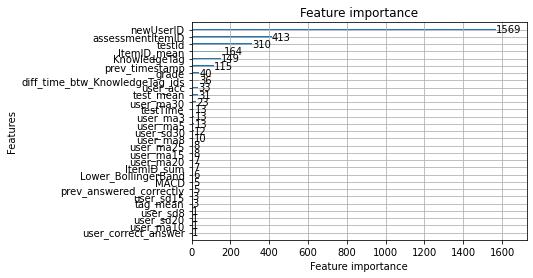

In [29]:
model = lgb.train(
#                     model_params, 
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    categorical_feature=categorical_features,
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(test_answer, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(test_answer, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
lgb.plot_importance(model)

# inference

In [724]:
# MAKE PREDICTION
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것

total_preds = model.predict(df_test_shift[FEATS])
# SAVE OUTPUT
output_dir = './'
prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0615_0122.csv


# k-fold 사용
### user 단위로 fold
### k-fold에는 validation이 조금 다릅니다.
### train에서 fold로 나눠진 val set + eval_dataset의 유저 마지막 답안을 제외한 시험지의 마지막 데이터를 concat해서 사용합니다

In [701]:
df_train = PP_train
df_test = PP_test

In [702]:
def get_eval_valset(df_train, df_test):    
    
    df_val = df_test[(df_test.testId != df_test.testId.shift(-1)) & (df_test.answerCode != -1)]
    df_train = df_train[df_train.testId != df_train.testId.shift(-1)]
    
    return df_train, df_val

df_train, df_test_val = get_eval_valset(df_train, df_test)

In [703]:
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

predicts = None
aucs = None

id_set = list(set(df_train.newUserID))
# validation
val_aucs = 0

## validation setting
test_val = df_test_val.drop(['answerCode'], axis=1)
test_val_answer = df_test_val['answerCode']

# MAKE PREDICTION
df_submit = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것
submit_predicts = np.zeros(df_submit.shape[0])

In [704]:
df = df_train.copy()
val_filter = "assessmentItemID"
train_filter = "test"

if val_filter == "assessmentItemID":
    df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
elif val_filter == "testId":
    df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.testId.isin(set_testId))]
elif val_filter == "KnowledgeTag":
     df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.KnowledgeTag.isin(set_tag))]

if train_filter == "test":
    df_train = df[df['testId'] != df['testId'].shift(-1)]
elif train_filter == "user":
    df_train = df[df['newUserID'] != df['newUserID'].shift(-1)]
else:
    df_train = df

In [705]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt', # rf, gbdt, dart, goss
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.9, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 1500, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': 42,
    'verbose': -1,
    'n_jobs': -1,    
    'learning_rate': 0.015,
    'max_depth': 15
}

In [706]:
# val_data = []
# for fold, (train_id, val_id) in enumerate(k_fold.split(df_val)):
#     val_data = df_val.iloc[val_id]
#     train_data = df_train[df_train.index.isin(val_data.index) == False]

[0] training start !!
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.845448	valid_1's auc: 0.836598
[200]	training's auc: 0.856462	valid_1's auc: 0.841181
[300]	training's auc: 0.864481	valid_1's auc: 0.843064
[400]	training's auc: 0.868354	valid_1's auc: 0.843586
[500]	training's auc: 0.870854	valid_1's auc: 0.843802
[600]	training's auc: 0.872785	valid_1's auc: 0.843887
[700]	training's auc: 0.874351	valid_1's auc: 0.843965
[800]	training's auc: 0.875718	valid_1's auc: 0.843973
Early stopping, best iteration is:
[702]	training's auc: 0.874412	valid_1's auc: 0.843998
VALID AUC : 0.8439981301046597 ACC : 0.7695841841470206

[1] training start !!
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.845444	valid_1's auc: 0.834658
[200]	training's auc: 0.856602	valid_1's auc: 0.83931
[300]	training's auc: 0.864683	valid_1's auc: 0.841354
[400]	training's auc: 0.868519	valid_1's auc: 0.841983
[500]	training's auc: 0.87

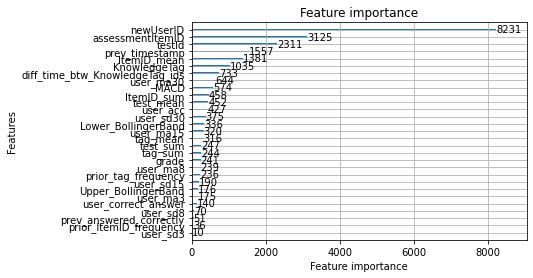

In [707]:
for fold, (train_id, val_id) in enumerate(k_fold.split(df_val)):
    print(f"[{fold}] training start !!")
    val_data = df_val.iloc[val_id]
    train_data = df_train[df_train.index.isin(val_data.index) == False]
    
    train = train_data.drop(['answerCode'], axis=1)
    train_answer = train_data['answerCode']
    
    # remain test dataset concat
    val = val_data.drop(['answerCode'], axis=1)
    val_answer = val_data['answerCode']
    all_val = pd.concat([val, test_val])
    all_val_answer = pd.concat([val_answer, test_val_answer])
    # 이건 test dataset 사용 X
#     all_val = val_data.drop(['answerCode'], axis=1)
#     all_val_answer = val_data['answerCode']    
    
    lgb_train = lgb.Dataset(train[FEATS], train_answer, free_raw_data=False)
    lgb_val = lgb.Dataset(all_val[FEATS], all_val_answer, free_raw_data=False)
    
    model = lgb.train(
                    model_params, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_val],
                    verbose_eval=100,
                    categorical_feature=categorical_features
                )

    val_preds = model.predict(all_val[FEATS])
    submit_preds = model.predict(df_submit[FEATS])
    
    val_acc = accuracy_score(all_val_answer, np.where(val_preds >= 0.5, 1, 0))
    val_auc = roc_auc_score(all_val_answer, val_preds)
    print(f'VALID AUC : {val_auc} ACC : {val_acc}\n')
    
    val_aucs += val_auc / 10
    submit_predicts += np.array(submit_preds) / 10
lgb.plot_importance(model)    
print(f"avg AUC : {val_aucs}")

In [376]:
# for fold, (train_id, val_id) in enumerate(k_fold.split(id_set)):

#     print(f"[{fold}] training start !!")
#     train_data = df_train[df_train.newUserID.isin(train_id)]    
#     val_data = df_train[df_train.newUserID.isin(train_id) == False]  

#     train = train_data.drop(['answerCode'], axis=1)
#     train_answer = train_data['answerCode']
    

#     val = val_data.drop(['answerCode'], axis=1)
#     val_answer = val_data['answerCode']
#     all_val = pd.concat([val, test_val])
#     all_val_answer = pd.concat([val_answer, test_val_answer])
    
    
#     lgb_train = lgb.Dataset(train[FEATS], train_answer, free_raw_data=False)
#     lgb_val = lgb.Dataset(all_val[FEATS], all_val_answer, free_raw_data=False)
    
#     model = lgb.train(
#                     model_params, 
#                     lgb_train,
#                     valid_sets=[lgb_train, lgb_val],
#                     verbose_eval=100,
#                     categorical_feature=categorical_features
#                 )

#     val_preds = model.predict(all_val[FEATS])
#     submit_preds = model.predict(df_submit[FEATS])
    
#     val_acc = accuracy_score(all_val_answer, np.where(val_preds >= 0.5, 1, 0))
#     val_auc = roc_auc_score(all_val_answer, val_preds)
#     print(f'VALID AUC : {val_auc} ACC : {val_acc}\n')
    
#     val_aucs += val_auc / 10
#     submit_predicts += np.array(submit_preds) / 10
# lgb.plot_importance(model)    
# print(f"avg AUC : {val_aucs}")

[0] training start !!
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.841508	valid_1's auc: 0.823766
[200]	training's auc: 0.854607	valid_1's auc: 0.825559
[300]	training's auc: 0.863733	valid_1's auc: 0.826634
[400]	training's auc: 0.867991	valid_1's auc: 0.826933
[500]	training's auc: 0.870883	valid_1's auc: 0.827037
[600]	training's auc: 0.873042	valid_1's auc: 0.827163
[700]	training's auc: 0.874768	valid_1's auc: 0.827156
Early stopping, best iteration is:
[615]	training's auc: 0.873341	valid_1's auc: 0.827198
VALID AUC : 0.8271976720852543 ACC : 0.7610078016458267

[1] training start !!
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.841632	valid_1's auc: 0.824373
[200]	training's auc: 0.854597	valid_1's auc: 0.826151
[300]	training's auc: 0.863681	valid_1's auc: 0.82712
[400]	training's auc: 0.867931	valid_1's auc: 0.827452
[500]	training's auc: 0.870818	valid_1's auc: 0.827601
[600]	training's auc: 0.87

KeyboardInterrupt: 

In [708]:
# SAVE OUTPUT
output_dir = './'
prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(submit_predicts):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0615_0117.csv


# pycaret

In [678]:
from pycaret.classification import *
from pycaret.utils import check_metric

In [686]:
if 'answerCode' not in FEATS:
    FEATS.append('answerCode')

In [682]:
df_train, df_test = PP_train, PP_test
df_train, df_val = get_full_valid_split(df_train, train_filter, val_filter, ratio=0) 

set()


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# def get_ideal_dtypes(df, df_test):
#     ideal_dtypes = dict()
    
#     for column in df.columns:
#         dtype = df[column].dtype
        
#         if dtype != object:
#             c_min = df[column].min()
#             c_max = df[column].max()

#             # 숫자형 데이터 형식 최적화
#             if str(dtype)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     ideal_dtypes[column] = 'int8'
#                 elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
#                     ideal_dtypes[column] = 'uint8'
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     ideal_dtypes[column] = 'int16'
#                 elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
#                     ideal_dtypes[column] = 'uint16'
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     ideal_dtypes[column] = 'int32'
#                 elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
#                     ideal_dtypes[column] = 'uint32'
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     ideal_dtypes[column] = 'int64'
#                 elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
#                     ideal_dtypes[column] = 'uint64'
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     ideal_dtypes[column] = 'float16'
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     ideal_dtypes[column] = 'float32'
#                 else:
#                     ideal_dtypes[column] = 'float64'
#         else:
#             df_full = pd.concat([df, df_test])
    
#             label_encoder = LabelEncoder()
#             #For UNKNOWN class
#             a = df_full[column].unique().tolist() + ['unknown']
#             label_encoder.fit(a)

#             #모든 컬럼이 범주형이라고 가정
#             df_full[column] = df_full[column].astype(str)
#             test = label_encoder.transform(df_full[column])
#             df_full[column] = test
#             ideal_dtypes[column] = 'category'
#     ideal_dtypes['KnowledgeTag'] = 'category'   
#     df_full = df_full.astype(ideal_dtypes)
#     return df_full[:len(df)], df_full[len(df):]
# PP_train, PP_test = get_ideal_dtypes(FE_train, FE_test)
# df_train, df_val = get_full_valid_split(df_train, train_filter, val_filter, ratio=0.1) 

In [688]:
random.seed(0)
settings = setup(data=df_train[FEATS],
                 target='answerCode',
                 train_size=0.9,
                 high_cardinality_features=categorical_features,
                 normalize=True,
                 normalize_method='robust',
                 use_gpu=True))

,Description,Value
0,session_id,6461
1,Target,answerCode
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(395040, 30)"
5,Missing Values,True
6,Numeric Features,21
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,True


In [689]:
lgbm = create_model('lightgbm', sort='AUC')
tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
final_lgbm = finalize_model(tuned_lgbm)

predict_model(lgbm)
predict_model(tuned_lgbm)
predict_model(final_lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7746,0.8459,0.8418,0.7756,0.8073,0.5369,0.5395
1,0.7757,0.8472,0.8405,0.7776,0.8078,0.5394,0.5418
2,0.7773,0.8503,0.8418,0.7790,0.8092,0.5427,0.5450
3,0.7713,0.8450,0.8389,0.7729,0.8045,0.5302,0.5328
4,0.7744,0.8463,0.8370,0.7777,0.8063,0.5370,0.5391
5,0.7751,0.8464,0.8420,0.7761,0.8077,0.5380,0.5406
6,0.7720,0.8457,0.8400,0.7732,0.8052,0.5315,0.5341
7,0.7778,0.8495,0.8403,0.7805,0.8093,0.5441,0.5462
8,0.7740,0.8473,0.8367,0.7774,0.8059,0.5362,0.5383
9,0.7773,0.8508,0.8424,0.7787,0.8093,0.5427,0.5451


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7754,0.8466,0.8385,0.7791,0.8077,0.5387,0.5408


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7783,0.8483,0.8399,0.7821,0.8099,0.5447,0.5467


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7839,0.8584,0.8453,0.7865,0.8148,0.5561,0.5582


,test_sum,ItemID_sum,tag_sum,user_correct_answer,user_acc,prev_timestamp,diff_time_btw_KnowledgeTag_ids,test_mean,ItemID_mean,tag_mean,...,grade,prev_answered_correctly_0.0,user_sd3_0.0,user_sd3_not_available,prior_ItemID_frequency_0,prior_ItemID_frequency_1,prior_ItemID_frequency_2,answerCode,Label,Score
0,0.231527,-0.896907,-0.448203,-1.0,-1.000000,2.207547,3.246914,-0.599550,-0.809422,-0.853283,...,-1.585511,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0.7985
1,0.532020,1.134021,0.306554,0.0,0.500000,-0.433962,-0.382716,0.415792,0.715815,0.259294,...,0.254778,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.7088
2,-0.179803,-0.804124,-0.107822,-0.5,-0.500000,-0.169811,-0.209877,-0.319088,-0.689353,-0.105310,...,-0.763163,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0.8958
3,-0.068966,-0.154639,-0.803911,-2.0,-1.500000,-0.509434,-0.432099,-1.501539,-0.602248,-1.384152,...,-1.820203,1.0,1.0,0.0,1.0,0.0,0.0,1,0,0.7039
4,0.201970,-0.103093,-0.816596,-1.5,-1.166667,-0.132075,1.518519,0.074324,0.179871,0.510882,...,-0.763163,0.0,1.0,0.0,1.0,0.0,0.0,0,0,0.6816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39499,0.204434,0.793814,0.458245,0.0,0.500000,-0.226415,-0.246914,0.602987,0.790214,0.689402,...,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0.9191
39500,0.487685,0.484536,0.507400,-1.0,-0.500000,-0.320755,-0.308642,0.369923,0.137657,0.266571,...,0.254778,1.0,0.0,1.0,1.0,0.0,0.0,0,0,0.9376
39501,-0.086207,0.237113,0.484672,-2.0,-1.500000,-0.433962,-0.382716,0.249730,0.203426,0.326560,...,0.059867,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0.9778
39502,0.135468,0.020619,-0.276427,-2.0,-1.500000,-0.452830,-0.370370,0.005521,0.334047,0.270828,...,-0.763163,1.0,1.0,0.0,1.0,0.0,0.0,0,0,0.9788


In [692]:
log = []
prediction = predict_model(final_lgbm, data=df_train[FEATS], raw_score = True)
print(f"train : {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
prediction = predict_model(final_lgbm, data=df_val[FEATS], raw_score = True)
print(f"validation :  {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")

KeyboardInterrupt: 

In [691]:
# MAKE PREDICTION
# SAVE OUTPUT
df_test_shift = df_test[df_test.answerCode == -1]
prediction = predict_model(final_lgbm, data=df_test_shift[FEATS], raw_score=True)
total_preds = prediction.Score_1.values

prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

output_dir = './'
write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0615_0100.csv
